In [0]:
import numpy as np
import torch
from torch import nn, optim

import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import save_image
from torchvision import datasets, transforms

In [0]:

model = None
use_cuda = True
if use_cuda and torch.cuda.is_available() and model is not None:
    model.cuda()
    
# GAN Lecture 2 (2018): Conditional Generator

In [0]:
class ModelDiscriminator(nn.Module):
    def __init__(self):
        super(ModelDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1  = nn.Linear(64*28*28+1000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.fc3 = nn.Linear(10, 1000)

    def forward(self, x, labels):
        """
        x obj
        """
        batch_size = x.size(0)
        x = x.view(batch_size, 1, 28,28)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = x.view(batch_size, 64*28*28)
        
        
        
        y_ = self.fc3(labels)
        y_ = F.relu(y_)
        # obj -> NN -> emb
        # label -> NN  -> emb2 
        # emb + emb2 -> NN -> score
        # usual archi -> weakness: dk whether is label and x dont match or x realistic or not
        
        # obj -> NN -> emb + x realistic not (score)
        # label + emb -> NN -> whether c and x match
        
        x = torch.cat([x, y_], 1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [0]:

class ModelGenerator(nn.Module):
    def __init__(self, z_dim):
        ## noise dimension
        self.z_dim = z_dim
        super(ModelGenerator, self).__init__()
        self.fc2 = nn.Linear(10, 1000)
        self.fc = nn.Linear(self.z_dim+1000, 64*28*28)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 5, 1, 2)

    def forward(self, x, labels):
        batch_size = x.size(0)
        y_ = self.fc2(labels)
        y_ = F.relu(y_)
        x = torch.cat([x, y_], 1)
        x = self.fc(x)
        x = x.view(batch_size, 64, 28, 28)
        x = self.bn1(x) 
        x = F.relu(x)
        x = self.deconv1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.deconv2(x)
        x = torch.sigmoid(x)
        return x

0it [00:00, ?it/s]

9920512it [00:02, 4556662.62it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 68069.08it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1131198.08it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 25674.78it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
torch.Size([28, 28, 1])
torch.Size([28, 28, 3])


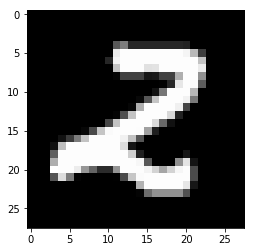

In [5]:
train_dataset = datasets.MNIST(root='data',train=True,download=True,transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, 64,shuffle=True)
sample1=[i for j,i in enumerate(train_loader) if j == 0 ][0]
sample1[0].shape
import matplotlib.pyplot as plt
print(sample1[0][0].permute(1,2,0).shape)
tensor_image = sample1[0][2]
tensor_image = tensor_image.view(tensor_image.shape[1], tensor_image.shape[2], tensor_image.shape[0])
tensor_image=tensor_image.repeat(1,1,3)
print(tensor_image.shape)
plt.imshow(tensor_image)

In [0]:
INPUT_SIZE=784 #28*28
NUM_LABELS = 10
SAMPLE_SIZE = 80
noise_dim=100
batch_size=128
cuda=True

#prev lr = 0.001 - too low result in generator instability
lr=0.05

train_dataset = datasets.MNIST(root='data',train=True,download=True,transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

model_d = ModelDiscriminator()
model_g = ModelGenerator(noise_dim)
criterion = nn.BCELoss()
input = torch.FloatTensor(batch_size, INPUT_SIZE)
noise = torch.FloatTensor(batch_size, noise_dim)

fixed_noise = torch.FloatTensor(SAMPLE_SIZE, noise_dim).normal_(0,1)
fixed_labels = torch.zeros(SAMPLE_SIZE, NUM_LABELS)
for i in range(NUM_LABELS):
    for j in range(SAMPLE_SIZE // NUM_LABELS):
        fixed_labels[i*(SAMPLE_SIZE // NUM_LABELS) + j, i] = 1.0
        
        
        
label = torch.FloatTensor(batch_size)
one_hot_labels = torch.FloatTensor(batch_size, 10)
if cuda:
    model_d.cuda()
    model_g.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
    one_hot_labels = one_hot_labels.cuda()
    fixed_labels = fixed_labels.cuda()

    
    
    
    

In [0]:
optim_d = optim.SGD(model_d.parameters(), lr=lr)
optim_g = optim.SGD(model_g.parameters(), lr=lr)
fixed_noise = Variable(fixed_noise)
fixed_labels = Variable(fixed_labels)

real_label = 1
fake_label = 0

In [120]:
"""
main training process
"""
n_epochs=10
print_every_batch = 200
for epoch_idx in range(n_epochs):
    d_loss = 0.0
    g_loss = 0.0
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        batch_size = train_x.size(0)
        train_x = train_x.view(-1, INPUT_SIZE)
        if cuda:
            train_x = train_x.cuda()
            train_y = train_y.cuda()
        
        input.resize_as_(train_x).copy_(train_x)
        label.resize_(batch_size).fill_(real_label)
        one_hot_labels.resize_(batch_size, NUM_LABELS).zero_()
        one_hot_labels.scatter_(1, train_y.view(batch_size,1), 1)
        inputv = Variable(input)
        labelv = Variable(label)

        output = model_d(inputv, Variable(one_hot_labels))
        optim_d.zero_grad()
        errD_real = criterion(output, labelv)
        errD_real.backward()
        realD_mean = output.data.cpu().mean()
        
        
        
        one_hot_labels.zero_()
        rand_y = torch.from_numpy(
            np.random.randint(0, NUM_LABELS, size=(batch_size,1))).cuda()
        one_hot_labels.scatter_(1, rand_y.view(batch_size,1), 1)
        noise.resize_(batch_size, noise_dim).normal_(0,1)
        label.resize_(batch_size).fill_(fake_label)
        noisev = Variable(noise)
        labelv = Variable(label)
        onehotv = Variable(one_hot_labels)
        g_out = model_g(noisev, onehotv)
        output = model_d(g_out, onehotv)
        errD_fake = criterion(output, labelv)
        fakeD_mean = output.data.cpu().mean()
        errD = errD_real + errD_fake
        errD_fake.backward()
        optim_d.step()
        

                # train the G
        noise.normal_(0,1)
        one_hot_labels.zero_()
        rand_y = torch.from_numpy(
            np.random.randint(0, NUM_LABELS, size=(batch_size,1))).cuda()
        one_hot_labels.scatter_(1, rand_y.view(batch_size,1), 1)
        label.resize_(batch_size).fill_(real_label)
        onehotv = Variable(one_hot_labels)
        noisev = Variable(noise)
        labelv = Variable(label)
        g_out = model_g(noisev, onehotv)
        output = model_d(g_out, onehotv)
        errG = criterion(output, labelv)
        optim_g.zero_grad()
        errG.backward()
        optim_g.step()
        
        
        # use torch tensor.data doesnt support index
        # use .item()
        d_loss += errD.data.item()
        g_loss += errG.data.item()
        if batch_idx % print_every_batch == 0:
            print("\t{} ({} / {}) mean D(fake) = {:.4f}, mean D(real) = {:.4f}".
                format(epoch_idx, batch_idx, len(train_loader), fakeD_mean,realD_mean))
            g_out = model_g(fixed_noise, fixed_labels).data.view(SAMPLE_SIZE, 1, 28,28).cpu()
    print('Epoch {} - D loss = {:.4f}, G loss = {:.4f}'.format(epoch_idx,d_loss, g_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


	0 (0 / 469) mean D(fake) = 0.5198, mean D(real) = 0.5016
	0 (200 / 469) mean D(fake) = 0.4953, mean D(real) = 0.5261
	0 (400 / 469) mean D(fake) = 0.4666, mean D(real) = 0.4779


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0 - D loss = 660.6104, G loss = 413.7406
	1 (0 / 469) mean D(fake) = 0.2506, mean D(real) = 0.3772
	1 (200 / 469) mean D(fake) = 0.6226, mean D(real) = 0.7158
	1 (400 / 469) mean D(fake) = 0.7230, mean D(real) = 0.9718
Epoch 1 - D loss = 486.4936, G loss = 601.0273
	2 (0 / 469) mean D(fake) = 0.2086, mean D(real) = 0.8037
	2 (200 / 469) mean D(fake) = 0.0873, mean D(real) = 0.5245
	2 (400 / 469) mean D(fake) = 0.0919, mean D(real) = 0.7040
Epoch 2 - D loss = 348.1879, G loss = 894.3997
	3 (0 / 469) mean D(fake) = 0.1575, mean D(real) = 0.6556
	3 (200 / 469) mean D(fake) = 0.1794, mean D(real) = 0.7181
	3 (400 / 469) mean D(fake) = 0.2341, mean D(real) = 0.7248
Epoch 3 - D loss = 365.3358, G loss = 887.5820
	4 (0 / 469) mean D(fake) = 0.6086, mean D(real) = 0.9220
	4 (200 / 469) mean D(fake) = 0.1684, mean D(real) = 0.7396
	4 (400 / 469) mean D(fake) = 0.3243, mean D(real) = 0.8152
Epoch 4 - D loss = 376.8078, G loss = 853.4461
	5 (0 / 469) mean D(fake) = 0.2926, mean D(real) = 0.

In [31]:
## sampling fixed labels
#g_out = model_g(fixed_noise, fixed_labels).data.view(SAMPLE_SIZE, 1, 28,28).cpu()
fixed_noise.shape,fixed_labels.shape


torch.Size([10, 1, 28, 28])

In [0]:

def plot_sample(model_g):
    plt.clf()
    plt.close()
    """
    @input param: takes in generator model with weights
    @output: plot images of all labels
    
    @model_g: takes in gaussian noise of nz (hyperparameter) and label (one-hot encoded) 
    """
    noise = torch.FloatTensor(10, noise_dim).normal_(0,1).cuda()
    labels = torch.zeros(10,10).cuda()
    for i in range(10):
        labels[i][i]=1
    g_out=model_g(noise,labels).data.view(10,1,28,28).cpu()
    plt.clf()
    plt.style.use('seaborn-muted')
    fig, axes = plt.subplots(2,5, 
                             figsize=(10,5),
                             sharex=True, sharey=True,
                             subplot_kw=dict(aspect='equal')) #https://stackoverflow.com/q/44703433/1870832
    img_to_plt=g_out.shape[0]
    for i in range(img_to_plt):
        # axes (subplot) objects are stored in 2d array, accessed with axes[row,col]
        # first // row , 2nd % row - to implement
        subplot_row = i//5
        subplot_col = i%5
        ax = axes[subplot_row, subplot_col]
        # plot image on subplot
        plottable_image = np.reshape(g_out.numpy()[i,:], (28,28))
        ax.imshow(plottable_image, cmap='gray_r')

        ax.set_title('Digit Label: {}'.format(np.where(labels.cpu().numpy()[i]==1)[0]))
        ax.set_xbound([0,28])
    plt.show()


<Figure size 432x288 with 0 Axes>

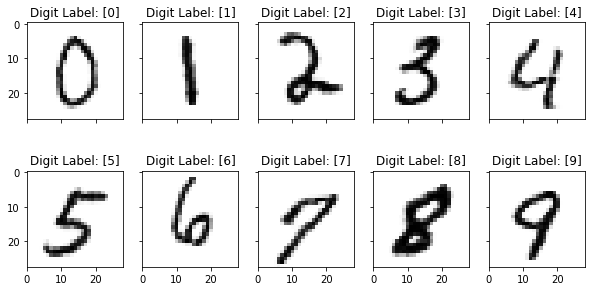

In [130]:
plot_sample(model_g)
plt.clf()
plt.close()